In [1]:
import torch
import timm
import numpy as np
from my_lib import *
from torch.utils.data import DataLoader
import pandas as pd
import tqdm

In [7]:
cfg = VisualConfig()
cfg.model_name = "timm/vit_base_patch32_clip_224.openai_ft_in1k"
cfg.csv_train_file = "dataset/train.csv"
cfg.csv_split_file = "dataset/fold.csv"
cfg.root_train_image = "dataset/images/train"
cfg.fold = 0
cfg.device = "cuda:0"

In [14]:
def get_embeddings(model, dataset, batch_size=64):
    #Important!
    model.eval()
    
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
    )
    
    emb_list = []

    for iter, (X, label) in enumerate(tqdm.tqdm(loader)):
        X = X.to(cfg.device)

        #Important!
        with torch.no_grad():
            #Important!
            embeddings = model.encode(X)
        
        emb_list += [embeddings.cpu().numpy()]

    # use vstack to stack vertically (B, num_classes) numpy arrays
    emb_list = np.vstack(emb_list)

    return emb_list

def get_predictions_vis(cfg, n_epochs=10, pretrained=None):
    vis_model = VisualModelTimm(cfg.model_name, num_classes=4, pretrained=True)

    if pretrained is not None:
        print(vis_model.load_state_dict(torch.load(pretrained)))
    
    train_transform = get_preprocessing(cfg, is_training=False)
    val_transform = get_preprocessing(cfg, is_training=False)
    test_transform = get_preprocessing(cfg, is_training=False)
    
    df = pd.read_csv(cfg.csv_train_file)
    split = pd.read_csv(cfg.csv_split_file)
    if cfg.fold == -1:
        df_train = df
        evaluate = False
    else:
        df_train = df.loc[split["fold"] != cfg.fold, :]
        df_val = df.loc[split["fold"] == cfg.fold, :]
        evaluate = True
    
    train_ds = DFDataset(cfg.root_train_images, df_train, transform=val_transform)
    val_ds = DFDataset(cfg.root_train_images, df_val, transform=val_transform)

    vis_model.to(cfg.device)
    train_emb_list = []
    y_train_list = []
    for i in range(n_epochs):
        train_emb = get_embeddings(vis_model, train_ds)
        train_emb_list.append(train_emb)
        y_train_list += [df_train["target"].values]
    
    
    train_emb = np.vstack(train_emb_list)
    y_train = np.concatenate(y_train_list)
    val_emb = get_embeddings(vis_model, val_ds)

    return (train_emb, y_train),  (val_emb, df_val["target"].values)

In [15]:
train_data_vis, val_data_vis = get_predictions_vis(cfg, 1)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  2.81it/s]


In [18]:
cfg = TextConfig()
cfg.csv_train_file = "dataset/train.csv"

def get_embeddings_text(model, dataset, batch_size=32) -> dict:
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
    )
    
    model.eval()
    emb_list = []

    for iter, batch in enumerate(tqdm.tqdm(loader)):
        input_ids = torch.stack(batch["input_ids"], 1).to(cfg.device)
        attention_mask = torch.stack(batch["attention_mask"], 1).to(cfg.device)
        
        with torch.no_grad():
            embeddings = model.encode(input_ids, attention_mask)
        
        emb_list += [embeddings.cpu().numpy()]

    # use vstack to stack vertically (B, num_classes) numpy arrays
    emb_list = np.vstack(emb_list)

    return emb_list

def get_predictions_text(n_epochs=10, pretrained=None):
    seed_everything(cfg.seed)
    
    text_model = NLPClassificationModel(cfg.model_name, cfg.num_classes, cfg.pretrained)

    if pretrained is not None:
        print(text_model.load_state_dict(torch.load(pretrained)))
    
    
    df = pd.read_csv(cfg.csv_train_file)
    split = pd.read_csv(cfg.csv_split_file)
    if cfg.fold == -1:
        df_train = df
        evaluate = False
    else:
        df_train = df.loc[split["fold"] != cfg.fold, :]
        df_val = df.loc[split["fold"] == cfg.fold, :]
        evaluate = True
    
    train_ds = dataset_from_pandas(df_train, cfg.model_name, cfg.batched, test=False)
    val_ds = dataset_from_pandas(df_val, cfg.model_name, cfg.batched, test=False)


    text_model.to(cfg.device)
    train_emb_list = []
    y_train_list = []
    for i in range(n_epochs):
        train_emb = get_embeddings_text(text_model, train_ds)
        train_emb_list.append(train_emb)
        y_train_list += [df_train["target"].values]
    
    train_emb = np.vstack(train_emb_list)
    y_train = np.concatenate(y_train_list)
    val_emb = get_embeddings_text(text_model, val_ds)

    
    return (train_emb, y_train),  (val_emb, df_val["target"].values)

In [19]:
train_data_text, val_data_text = get_predictions_text(1)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\alenic\gitrepo\training-camp-sep-2024\baseline_official\my_lib\dataset_text.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["description"] = df["object"] + ": " + df["description"]


Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 12.93it/s]


# Training

In [89]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

In [91]:
def train_xgb(train_data, val_data, test_data):
    X_train, y_train = train_data
    X_val, y_val = val_data
    X_test, y_test = test_data
    
    cls= XGBClassifier()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print("Val acc", acc)


In [92]:
def train_svm(train_data, val_data, test_data):
    X_train, y_train = train_data
    X_val, y_val = val_data
    X_test, y_test = test_data
    cls= SVC()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print("Val acc", acc)


In [93]:
def train_linear(train_data, val_data, test_data):
    X_train, y_train = train_data
    X_val, y_val = val_data
    X_test, y_test = test_data
    cls= LogisticRegression()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print("Val acc", acc)


In [94]:
train_xgb(train_data_vis, val_data_vis, test_data_vis)

Val acc 0.52125


In [95]:
train_svm(train_data_vis, val_data_vis, test_data_vis)

Val acc 0.55375


In [96]:
train_linear(train_data_vis, val_data_vis, test_data_vis)

Val acc 0.4675


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [99]:
from sklearn.manifold import TSNE

In [102]:
X_2 = TSNE().fit_transform(train_data_vis[0])

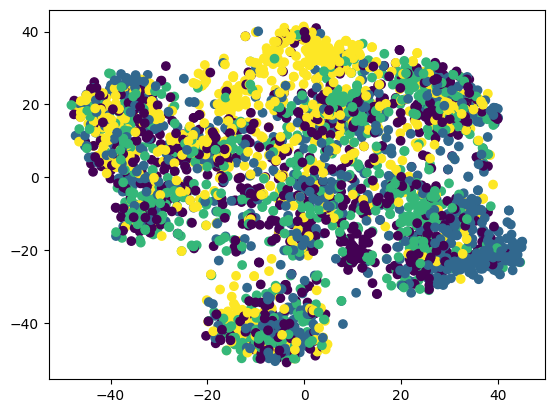

In [105]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X_2[:,0], X_2[:,1], c=train_data_vis[1])

In [108]:
X_train_test = np.vstack([train_data_vis[0], test_data_vis[0]])
y_train_test = np.concatenate([np.zeros(len(train_data_vis[0])), np.ones(len(test_data_vis[0]))])

In [109]:
X_train_test.shape

(4200, 768)

In [111]:
X_train_test_2 = TSNE().fit_transform(X_train_test)

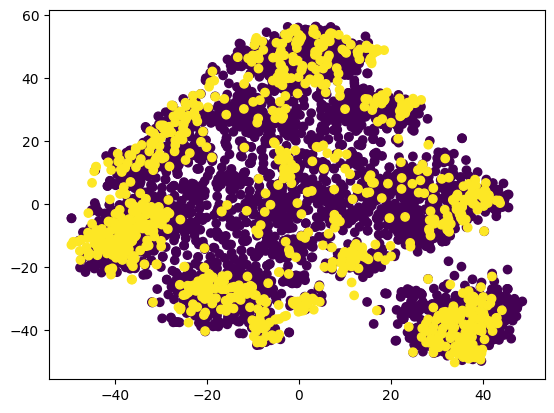

In [112]:
plt.figure()
plt.scatter(X_train_test_2[:,0], X_train_test_2[:,1], c=y_train_test)

In [120]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_test, y_train_test)

binary_cls = SVC().fit(X_train, y_train)
y_pred = binary_cls.predict(X_val)
accuracy_score(y_val, y_pred)

0.820952380952381

In [77]:
train_multimodal = (np.hstack([train_data_vis[0], train_data_vis[0]]), train_data_vis[1])
val_multimodal = (np.hstack([val_data_vis[0], val_data_vis[0]]), val_data_vis[1])
test_multimodal = (np.hstack([test_data_vis[0], test_data_vis[0]]), test_data_vis[1])